In [3]:
import torchvision
import torch
import numpy as np
from torch import nn

In [96]:
inst_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [150]:
print(inst_classes.index('bench'))

15


In [4]:
def get_dist(boxes, labels, w, h, nums=10):
  person, dog = 1, 18
  boxes = boxes.tolist()[:nums]
  labels = labels.tolist()[:nums]
  person_cs, dog_cs = [], []
  get_center = lambda box: ((box[0] + box[2]) / 2, (box[1] + box[3]) / 2)
  for i in range(len(boxes)):
    if labels[i] == person: 
      person_cs.append(get_center(boxes[i]))
    if labels[i] == dog: 
      dog_cs.append(get_center(boxes[i]))
  dist = [[0 for j in range(len(dog_cs))] for i in range(len(person_cs))]
  print (dog_cs, person_cs)
  for i in range(len(person_cs)):
    for j in range(len(dog_cs)):
      dist[i][j] = ((person_cs[i][0] - dog_cs[j][0]) ** 2 + (person_cs[i][1] -
                                                  dog_cs[j][1]) ** 2) ** 0.5
  return np.min(dist) / (w ** 2 + h ** 2) ** 0.5 #!!!!!по теореме Пифагора

In [130]:
def update_get_dist(a1, a2, boxes, labels, nums=10):
  person, dog = a1, a2
  boxes = boxes.tolist()[:nums]
  labels = labels.tolist()[:nums]
  person_cs, dog_cs = [], []
  for i in range(len(boxes)):
    if labels[i] == person: 
      person_cs.append(boxes[i])
    if labels[i] == dog: 
      dog_cs.append(boxes[i])
  dist = [[0 for j in range(len(dog_cs))] for i in range(len(person_cs))]
  for i in range(len(person_cs)):
    for j in range(len(dog_cs)):

      delta_x = abs((person_cs[i][2] + person_cs[i][0]) / 2 -  
                    (dog_cs[j][2] + dog_cs[j][0]) / 2) / ((dog_cs[j][2] - dog_cs[j][0]))

      delta_y = abs((person_cs[i][3] + person_cs[i][1]) / 2 -  
                    (dog_cs[j][3] + dog_cs[j][1]) / 2) / (person_cs[i][3] - person_cs[i][1])

      dist[i][j] = max(delta_x, delta_y)
  return dist

In [97]:
def draw_pic_with_rect(picture, boxes, labels, n=5):
    boxes = boxes[:n]
    labels = labels[:n]
    if isinstance(picture, torch.Tensor):
        picture = (picture.detach().squeeze(0) * 256).permute(1, 2, 0).numpy()
    picture = picture.astype(dtype=np.int)

    fig, ax = plt.subplots(figsize = (15, 15))
    ax.imshow(picture)

    for box, lab in zip(boxes, labels):
        rect = matplotlib.patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                       linewidth=1, edgecolor='r', facecolor='none')
        ax.text(box[0], box[1], inst_classes[lab], fontsize = 12)
        ax.add_patch(rect)

    fig.show()

In [59]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from torchvision.models import detection
import torchvision
from tqdm import tqdm, tqdm_notebook
from PIL import Image

In [60]:

def get_cropped_image(picture, coordinates, expand_coeff=2.0):
        '''
            picture: torch.Tensor
            coordinates: "indexed set" of 4 coordinates: [x1, y1, x2, y2]
        '''
        x = coordinates[0]
        y = coordinates[1]
        w = coordinates[2] - coordinates[0]
        h = coordinates[3] - coordinates[1]
        w_expanded = int(w * expand_coeff)
        h_expanded = int(h * expand_coeff)
        x_expanded = int(x - (w_expanded - w) / 2.0)
        y_expanded = int(y - (h_expanded - h) / 2.0)

        return torchvision.transforms.functional.crop(
            picture, 
            int(y_expanded), 
            int(x_expanded), 
            int(h_expanded), 
            int(w_expanded),
        )

In [5]:
# !unzip -q drive/MyDrive/leadersd/name.zip

In [67]:
model_detection = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained = True)
model_detection.eval();

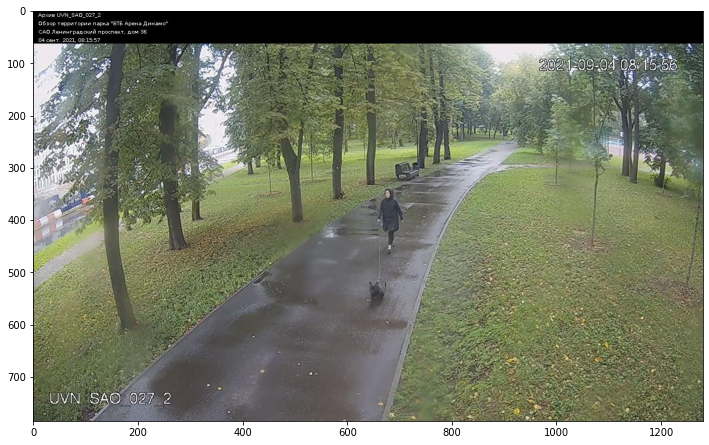

In [152]:
image = Image.open("/content/Датасет/Хозяин и собака/408.jpg")
image_numpy = np.asarray(image)
plt.figure(figsize=(12, 10))
plt.imshow(image_numpy)

In [153]:
picture_torch = torch.tensor(image_numpy).permute(2, 0, 1).unsqueeze(0)/256
predict = model_detection(picture_torch)
print(predict)

[{'boxes': tensor([[ 660.7761,  336.8130,  708.1500,  463.5919],
        [ 692.4656,  289.0241,  741.1198,  325.5499],
        [1081.8763,  243.5669, 1124.1688,  285.8849],
        [1179.7338,  269.5804, 1207.3220,  338.5606],
        [ 240.9895,  178.5104,  277.1545,  243.5025],
        [1172.2667,  273.2822, 1201.5778,  302.9264],
        [1155.5292,  268.9142, 1171.8629,  297.7416],
        [1193.1504,  279.4835, 1223.7799,  340.4952],
        [1170.9897,  273.7941, 1202.5934,  301.1012]], grad_fn=<StackBackward>), 'labels': tensor([ 1, 15,  3,  1, 10,  1,  3,  1,  3]), 'scores': tensor([0.9974, 0.8947, 0.2314, 0.1537, 0.0960, 0.0858, 0.0669, 0.0642, 0.0620],
       grad_fn=<IndexBackward>)}]


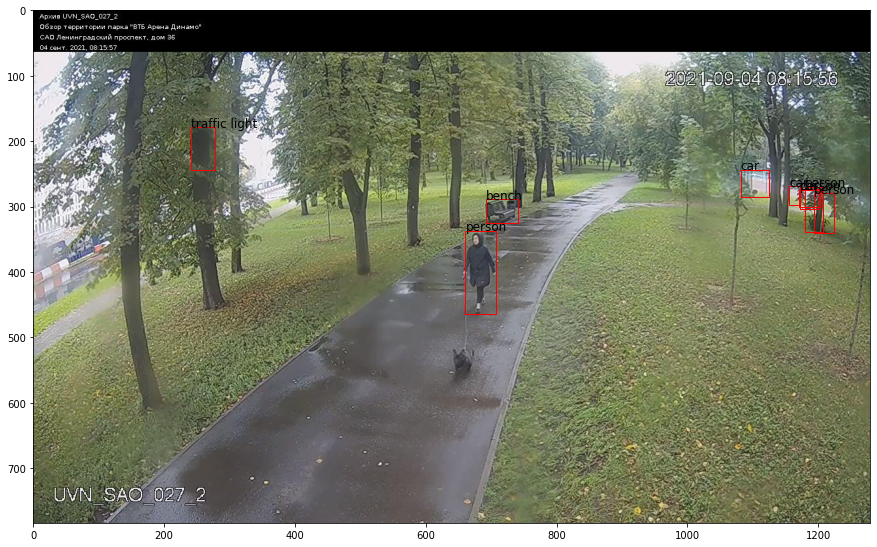

In [154]:
draw_pic_with_rect(picture_torch, predict[0]['boxes'], predict[0]['labels'], 25)

In [151]:
  print(update_get_dist(1, 15, predict[0]['boxes'], predict[0]['labels'], 25))

[[1.4016721794681994, 1.5849787125554313, 2.6342538726359646, 2.012235929716599, 1.0647171278911773, 1.4515008028197958]]


In [108]:
print(predict[0]['boxes'].tolist())

[[654.5103149414062, 470.75616455078125, 708.6607666015625, 635.9472045898438], [398.57708740234375, 455.9894104003906, 499.297607421875, 530.3609008789062], [668.2460327148438, 468.9600830078125, 941.5821533203125, 618.8673706054688], [590.5726318359375, 449.2367858886719, 693.962158203125, 514.7131958007812], [284.8807067871094, 513.8416137695312, 424.78961181640625, 594.7877807617188], [502.0916748046875, 449.7082214355469, 603.858154296875, 538.2261962890625], [824.2384643554688, 553.2452392578125, 962.8565063476562, 691.2199096679688], [893.96533203125, 446.0800476074219, 988.2911376953125, 504.0595397949219], [673.431884765625, 448.55731201171875, 768.9111328125, 485.91888427734375], [695.240234375, 444.68890380859375, 781.2876586914062, 474.7386474609375], [551.5245971679688, 592.9063110351562, 625.442138671875, 645.7314453125], [320.3828430175781, 448.7557373046875, 413.5965576171875, 514.4822387695312], [0.0, 407.19158935546875, 381.7581787109375, 770.720458984375], [806.77996

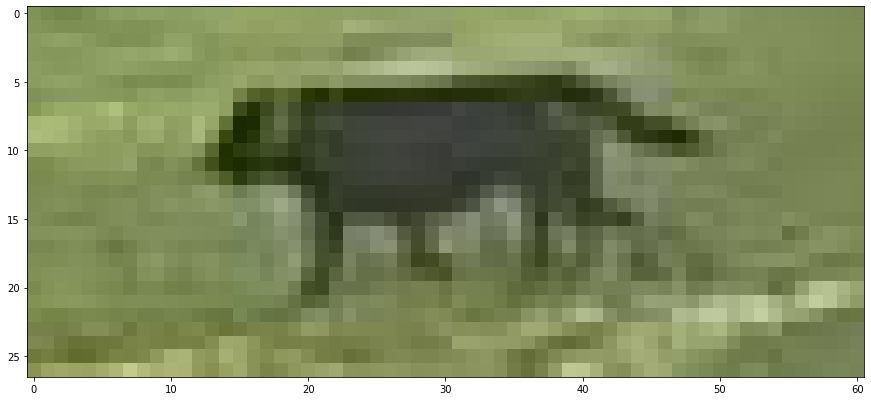

In [23]:
cropped_image = get_cropped_image(picture_torch, predict[0]['boxes'][0], 1.5)
draw_pic_with_rect(cropped_image, [], [])

In [24]:
cropped_image.shape

torch.Size([1, 3, 27, 61])

In [28]:
im_numpy = (cropped_image[0].permute(1, 2, 0).detach().numpy() * 256).astype(np.uint8)

In [30]:
rgb = Image.fromarray(im_numpy)

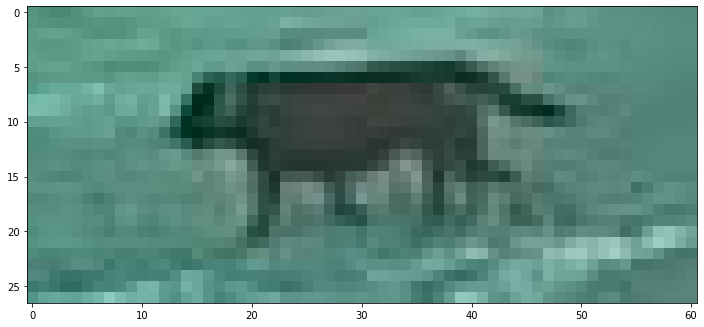

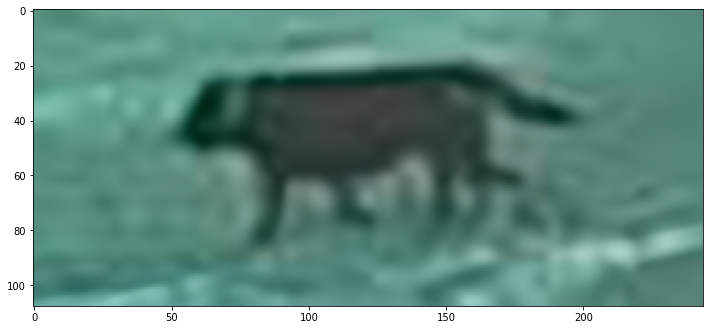

In [52]:
sr = cv2.dnn_superres.DnnSuperResImpl_create()

path = "EDSR_x4.pb"
sr.readModel(path)
sr.setModel("edsr",4)
result = sr.upsample(im_numpy)
# plt.figure(figsize=(12,8))
# plt.imshow(im_numpy[:,:,::-1])
# plt.show()
plt.figure(figsize=(12,8))
plt.imshow(result[:,:,::-1])


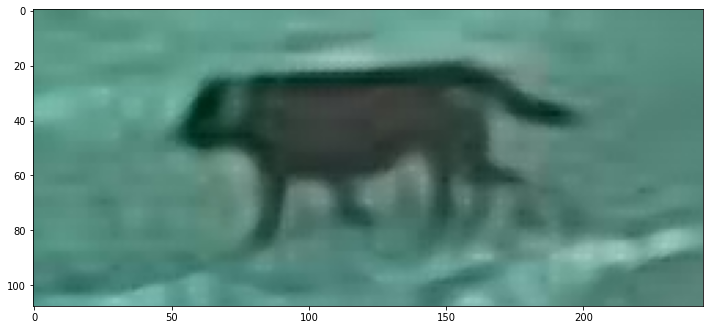

In [56]:
sr = cv2.dnn_superres.DnnSuperResImpl_create()

path = "FSRCNN_x4.pb"
sr.readModel(path)
sr.setModel("fsrcnn",4)
result = sr.upsample(im_numpy)
# plt.figure(figsize=(12,8))
# plt.imshow(im_numpy[:,:,::-1])
# plt.show()
plt.figure(figsize=(12,8))
plt.imshow(result[:,:,::-1])

In [ ]:
plt

In [ ]:
pip install ISR

In [42]:
from ISR.models import RDN

rdn = RDN(weights='psnr-small')

sr_img = rdn.predict(im_numpy)
Image.fromarray(sr_img)

AttributeError: ignored